#### This two layer collusion codes is based on Mojtaba Tefagh codes in his post (https://hackmd.io/c6kyRNMuTnKf_SlolmevRg).

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import secrets
%config InlineBackend.figure_format = 'svg'

class Transaction:
    def __init__(self, gas_premium, fee_cap, gas_used,waiting_limit):
        self.gas_premium = gas_premium
        self.fee_cap = fee_cap
        self.gas_used = gas_used
        self.tx_hash = secrets.token_bytes(8)
        self.waiting_limit = waiting_limit
        self.sent_to_memepool = False
        
    def __lt__(self, other):
        return self.gas_premium < other.gas_premium

In [3]:
import pandas as pd

# cadCAD configuration modules
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

# cadCAD simulation engine modules
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

In [4]:
constants = {
    "BASEFEE_MAX_CHANGE_DENOMINATOR": 8,
    "TARGET_GAS_USED": 12500000,
    "MAX_GAS_EIP1559": 25000000,
    "INITIAL_BASEFEE": 1 * (10 ** 9),
}

In [5]:
# state update function

from random import randint

def update_demand_variable(params, step, sL, s, _input):
    # dict of transactions as a demand
    demand = s["demand"]
    latest_block = s["latest_block"]
    
    # adding new transactions
    for i in range(500):
        gas_premium = randint(1, 10) * (10 ** 8)
        fee_cap = gas_premium + randint(1, 10) * (10 ** 9)
        waiting_limit = 5*(randint(1, 100)<=25)
        tx = Transaction(
            gas_premium = gas_premium,
            gas_used = 25000,
            fee_cap = fee_cap,
            waiting_limit = waiting_limit
        )
        demand[tx.tx_hash] = tx
        
    for tx in latest_block.txs:
        demand.pop(tx.tx_hash)
    
    # estimation of next block size
    basefee = s["basefee"]
    miner_gains = 0
    txs_included = []
    
    for tx_hash, tx in demand.items():
        if not is_valid(tx, basefee):
            continue
        if not tx.sent_to_memepool:
            continue
        gas_price = min([basefee + tx.gas_premium, tx.fee_cap])
        miner_gains += (gas_price - basefee) * tx.gas_used
        txs_included += [tx]
        
    gas_used = sum([tx.gas_used for tx in txs_included])
    is_full = gas_used > 0.5*constants["TARGET_GAS_USED"]
    
    # send transactions and update waiting limit
    for tx_hash, tx in demand.items():
        if tx.waiting_limit == 0 or is_full:
            tx.sent_to_memepool = True
        if tx.waiting_limit>0:
            tx.waiting_limit = tx.waiting_limit-1
        
    return ("demand", demand)

In [6]:
class Block():
    def __init__(self, txs):
        self.txs = txs
        
def is_valid(tx, basefee):
    return tx.fee_cap >= basefee

In [7]:
# policy function

def include_valid_txs(params, step, sL, s):
    demand = s["demand"]
    basefee = s["basefee"]
    miner_gains = 0
    txs_included = []
    
    for tx_hash, tx in demand.items():
        # include valid transactions
        if not is_valid(tx, basefee):
            continue
        # include sent transactions
        if not tx.sent_to_memepool:
            continue
        
        
        gas_price = min([basefee + tx.gas_premium, tx.fee_cap])
        miner_gains += (gas_price - basefee) * tx.gas_used
        txs_included += [tx]
        
    assert miner_gains >= 0
    return ({ "block": Block(txs = txs_included) })

In [8]:
# state update function

def update_basefee(params, step, sL, s, _input):
    block = _input["block"]
    basefee = s["basefee"]
    
    gas_used = sum([tx.gas_used for tx in block.txs])
    delta = gas_used - constants["TARGET_GAS_USED"]
    new_basefee = basefee + basefee * delta / constants["TARGET_GAS_USED"] / constants["BASEFEE_MAX_CHANGE_DENOMINATOR"]
    
    return ("basefee", new_basefee)

In [9]:
# state update function

def get_gas_used(params, step, sL, s, _input):
    block = _input["block"]
    
    gas_used = sum([tx.gas_used for tx in block.txs])
    
    return ("gasused", gas_used)

In [10]:
# state update function

def get_miner_gains(params, step, sL, s, _input):
    block = _input["block"]
    basefee = s["basefee"]
    
    miner_gains = sum([tx.gas_used*(min([basefee + tx.gas_premium, tx.fee_cap]) - basefee) for tx in block.txs])

    return ("miner_revenue", miner_gains)

In [11]:
# state update function

def record_latest_block(params, step, sL, s, _input):
    block = _input["block"]
    
    return ("latest_block", block)

In [12]:
%%capture
from cadCAD import configs

# initiate first attempt to reduce base fee

gas_premium = randint(1, 10) * (10 ** 8)
fee_cap = gas_premium + randint(1, 10) * (10 ** 9)
waiting_limit = 5
tx = Transaction(
gas_premium = gas_premium,
gas_used = 25000,
fee_cap = fee_cap,
waiting_limit = waiting_limit
)
de = {}
de[tx.tx_hash] = tx

# this entire structure represents one timestep

psub = [
    # first partial state update block, and one substep
    {
    # policy functions
    "policies": {},
    # state update functions
    "variables": {
        "demand": update_demand_variable # step 1
    }
}, 
    # second partial state update block
    {
    # policy functions
    "policies": {
        "action": include_valid_txs # step 2
    },
    # state update functions
    "variables": {
        "basefee": update_basefee, # step 3
        "latest_block": record_latest_block,
        "gasused": get_gas_used,
        "miner_revenue": get_miner_gains
    }
}]


initial_conditions = {
    "basefee": constants['INITIAL_BASEFEE'],
    "demand": de,
    "latest_block": Block(txs=[]),
    "gasused": 0,
    "miner_revenue": 0
}

del configs[:]

simulation_parameters = config_sim({
    'T': range(20000),  # number of timesteps
    'N': 1  # number of Monte Carlo runs
})

experiment = Experiment()
experiment.append_configs(
    # model initial state
    initial_state = initial_conditions,
    # model partial state update blocks
    partial_state_update_blocks = psub,
    # simulation configuration
    sim_configs = simulation_parameters
)

exec_context = ExecutionContext()
simulation = Executor(exec_context=exec_context, configs=configs)
raw_result, tensor, sessions = simulation.execute()

# convert cadCAD raw results from list of dictionaries to Pandas DataFrame format
df = pd.DataFrame(raw_result)

In [13]:
df

,basefee,demand,latest_block,gasused,miner_revenue,simulation,subset,run,substep,timestep
0,1.000000e+09,{b'\x8e\xa2\xc3\x8c\xe7\xd5*\xd7': <__main__.T...,<__main__.Block object at 0x7f94201ab9a0>,0,0.000000e+00,0,0,1,0,0
1,1.000000e+09,{b'\x8e\xa2\xc3\x8c\xe7\xd5*\xd7': <__main__.T...,<__main__.Block object at 0x7f94201c6b20>,0,0.000000e+00,0,0,1,1,1
2,9.692500e+08,{b'\x8e\xa2\xc3\x8c\xe7\xd5*\xd7': <__main__.T...,<__main__.Block object at 0x7f94102ae760>,9425000,5.137500e+15,0,0,1,2,1
3,9.692500e+08,{b'\x8e\xa2\xc3\x8c\xe7\xd5*\xd7': <__main__.T...,<__main__.Block object at 0x7f94201cf490>,9425000,5.137500e+15,0,0,1,1,2
4,9.430802e+08,{b'\x8e\xa2\xc3\x8c\xe7\xd5*\xd7': <__main__.T...,<__main__.Block object at 0x7f948087e5b0>,9800000,5.230000e+15,0,0,1,2,2
...,...,...,...,...,...,...,...,...,...,...
39996,7.570238e+08,{b'P\xd4\xe9\xb4A\x94#\x1f': <__main__.Transac...,<__main__.Block object at 0x7f90054c9580>,12400000,6.865000e+15,0,0,1,2,19998
39997,7.570238e+08,{b'\x00\xa6@\x06\x124\xb5\x9a': <__main__.Tran...,<__main__.Block object at 0x7f90054b1a30>,12400000,6.865000e+15,0,0,1,1,19999
39998,7.560775e+08,{b'\x00\xa6@\x06\x124\xb5\x9a': <__main__.Tran...,<__main__.Block object at 0x7f9005581970>,12375000,6.717500e+15,0,0,1,2,19999
39999,7.560775e+08,{b'\xc2%:\xfe\x9fX\xac\xc2': <__main__.Transac...,<__main__.Block object at 0x7f90055741f0>,12375000,6.717500e+15,0,0,1,1,20000


<AxesSubplot:xlabel='timestep'>

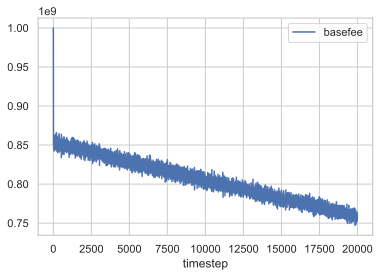

In [14]:
sns.set(style="whitegrid")
df[df.substep == 1].plot('timestep', ['basefee'])

In [30]:
#sns.set(style="whitegrid")
#fig = df[50:][df.substep == 1].plot('timestep', ['basefee']).get_figure()
#fig.savefig("two_layer_collusion") 

/var/folders/mp/4swd5jd5049422cbl8594djh0000gn/T/ipykernel_1021/1545614963.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[50:][df.substep == 1].plot('timestep', ['basefee'])


<AxesSubplot:xlabel='timestep'>

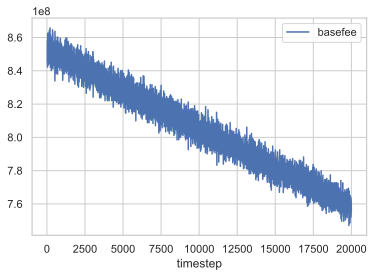

In [16]:
sns.set(style="whitegrid")
df[50:][df.substep == 1].plot('timestep', ['basefee'])

/var/folders/mp/4swd5jd5049422cbl8594djh0000gn/T/ipykernel_1021/369567628.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[50:][df.substep == 1].plot('timestep', ['gasused'])


<AxesSubplot:xlabel='timestep'>

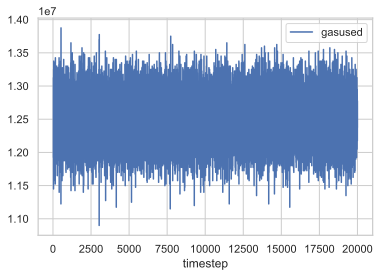

In [17]:
sns.set(style="whitegrid")
df[50:][df.substep == 1].plot('timestep', ['gasused'])

In [18]:
df_new = df[['miner_revenue','gasused']]

In [19]:
df_new = df_new.cumsum()

In [20]:
df_new['timestep'] = df['timestep']

In [21]:
df_new['substep'] = df['substep']

In [22]:
df_new.rename(columns={'gasused': 'cumulative_gas_used'}, inplace=True)

In [23]:
df_new

,miner_revenue,cumulative_gas_used,timestep,substep
0,0.000000e+00,0,0,0
1,0.000000e+00,0,1,1
2,5.137500e+15,9425000,1,2
3,1.027500e+16,18850000,2,1
4,1.550500e+16,28650000,2,2
...,...,...,...,...
39996,2.749792e+20,499905850000,19998,2
39997,2.749861e+20,499918250000,19999,1
39998,2.749928e+20,499930625000,19999,2
39999,2.749995e+20,499943000000,20000,1


/var/folders/mp/4swd5jd5049422cbl8594djh0000gn/T/ipykernel_1021/4143057866.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_new[50:][df_new.substep == 1].plot('timestep', ['cumulative_gas_used'])


<AxesSubplot:xlabel='timestep'>

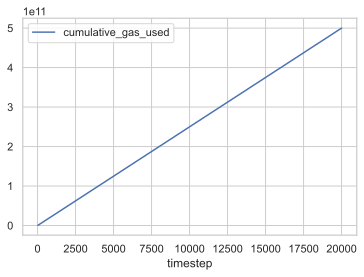

In [24]:
sns.set(style="whitegrid")
df_new[50:][df_new.substep == 1].plot('timestep', ['cumulative_gas_used'])

In [32]:
#sns.set(style="whitegrid")
#fig = df_new[50:][df_new.substep == 1].plot('timestep', ['cumulative_gas_used']).get_figure()
#fig.savefig("two_layer_collusion_gas_used") 